# Inteligência Artificial Explicável (XAI) Usando o Conjunto de Dados de Marketing Bancário

**Objetivo:**
Aprimorar a compreensão sobre Inteligência Artificial Explicável (XAI) aplicando técnicas de aprendizado de máquina ao conjunto de dados de Marketing Bancário e interpretando as saídas do modelo com ênfase nos princípios de XAI.


---



In [349]:
# Instalação de bibliotecas
%pip install pycaret
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fa63565c0fc0047da3e5bc34273687ea5e5b545a3505a0ca330b6b417a06ae99
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [420]:
# Importação das bibliotecas

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import numpy as np
import joblib

from pycaret.datasets import get_data
from pycaret.classification import *
from re import S
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [377]:
# Conexão com o Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 - Visão Geral do Conjunto de Dados
* Fornecer uma visão detalhada do conjunto de dados de Marketing Bancário, enfatizando os atributos e a variável alvo (Coluna Y).
* Discutir as etapas de pré-processamento de dados necessárias antes da aplicação dos modelos de aprendizado de máquina, como tratamento de valores ausentes, codificação de variáveis categóricas e
escalonamento de características numéricas.

In [378]:
# Carregar os dados do arquivo CSV.
# Exibir as primeiras linhas do conjunto de dados

# Caminho do arquivo
file_path = "/content/drive/MyDrive/Pessoal/Educação/Católica de Santa Catarina - Pós-Graduação/09 - Avaliação de Resultados e Análise de Dados com IA/Trabalho Final/CatolicaSC_AvaliacaoAnaliseResultados_Entrega01/bank-additional-full.csv"

# Leitura do arquivo com separador ";"
data = pd.read_csv(file_path, sep=';')

In [379]:
# Análise Exploratória dos dados
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Variáveis

## Pessoais e Financeiras:
* **age** (numérico): Pode ser usada diretamente como uma variável numérica ou categorizada em faixas etárias, dependendo da análise.
* **job** (categórico): Requer codificação de variáveis categóricas, como One-Hot Encoding ou Label Encoding, dependendo do modelo.
* **marital** (categórico): Similar a job, precisa de codificação.
* **education** (categórico): Precisa de codificação.
* **default** (categórico): Se o cliente está em default ou não. Codificar como variável binária.
* **housing** (categórico): Se o cliente tem empréstimo imobiliário. Codificar como variável binária.
* **loan** (categórico): Se o cliente tem empréstimo pessoal. Codificar como variável binária.
# Relacionados ao Último Contato:
* **contact** (categórico): Tipo de contato utilizado. Precisa ser codificado.
* **month** (categórico): Mês de contato pode ser tratado como ordinal ou codificado como One-Hot.
* **day_of_week** (categórico): Precisa ser codificado.
* **duration** (numérico): Como mencionado, essa variável deve ser removida se você estiver criando um modelo preditivo realista, pois é uma variável conhecida após o evento.
# Outras Variáveis:
* **campaign** (numérico): Usada diretamente.
* **pdays** (numérico): Atenção ao valor especial 999, que deve ser tratado adequadamente.
* **previous** (numérico): Número de contatos anteriores pode ser usada diretamente.
* **poutcome** (categórico): Resultado da campanha anterior, requer codificação.
# Variáveis Econômicas:
* **emp.var.rate** (numérico): Indicador trimestral.
* **cons.price.idx** (numérico): Indicador mensal de preços.
* **cons.conf.idx** (numérico): Índice de confiança do consumidor.
* **euribor3m** (numérico): Taxa de 3 meses Euribor.
nr.employed (numérico): Número de empregados.
# Variável Alvo (Saída):
* **y** (binário): A variável alvo, se o cliente subscreveu ou não um depósito a prazo. Deve ser codificada como binária (0 ou 1).

In [380]:
# Cálculo de estatísticas descritivas
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [381]:
# Número de Linhas e colunas
data.shape

(41188, 21)

In [382]:
#Avaliar valores nulos
missing_values = data.isnull().sum()
print(missing_values)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [383]:
# Contar o número de ocorrências de "unknown" em cada coluna
unknown_counts = (data == 'unknown').sum()

# Filtrar e exibir apenas as colunas que possuem "unknown"
unknown_columns = unknown_counts[unknown_counts > 0]
print(unknown_columns)

job           330
marital        80
education    1731
default      8597
housing       990
loan          990
dtype: int64


In [384]:
# Substituir "unknown" por NaN
data_cleaned = data.replace('unknown', pd.NA)

# Remover as linhas que contêm NaN
data_cleaned = data_cleaned.dropna()

# Exibir as primeiras linhas do DataFrame limpo
print(data_cleaned.head())

   age        job  marital            education default housing loan  \
0   56  housemaid  married             basic.4y      no      no   no   
2   37   services  married          high.school      no     yes   no   
3   40     admin.  married             basic.6y      no      no   no   
4   56   services  married          high.school      no      no  yes   
6   59     admin.  married  professional.course      no      no   no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0  telephone   may         mon  ...         1    999         0  nonexistent   
2  telephone   may         mon  ...         1    999         0  nonexistent   
3  telephone   may         mon  ...         1    999         0  nonexistent   
4  telephone   may         mon  ...         1    999         0  nonexistent   
6  telephone   may         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          1.1  

In [385]:
# Contar o número de ocorrências de "illiterate" em cada coluna
illiterate_counts = (data_cleaned == 'illiterate').sum()

# Filtrar e exibir apenas as colunas que possuem "illiterate"
illiterate_columns = illiterate_counts[illiterate_counts > 0]
print(illiterate_columns)

education    11
dtype: int64


In [386]:
# Substituir "illiterate" por NaN
data_cleaned = data_cleaned.replace('illiterate', pd.NA)

# Remover as linhas que contêm NaN
data_cleaned = data_cleaned.dropna()

# Exibir as primeiras linhas do DataFrame limpo
print(data_cleaned.head())

   age        job  marital            education default housing loan  \
0   56  housemaid  married             basic.4y      no      no   no   
2   37   services  married          high.school      no     yes   no   
3   40     admin.  married             basic.6y      no      no   no   
4   56   services  married          high.school      no      no  yes   
6   59     admin.  married  professional.course      no      no   no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0  telephone   may         mon  ...         1    999         0  nonexistent   
2  telephone   may         mon  ...         1    999         0  nonexistent   
3  telephone   may         mon  ...         1    999         0  nonexistent   
4  telephone   may         mon  ...         1    999         0  nonexistent   
6  telephone   may         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          1.1  

In [387]:
# One-Hot Encoding:
# Cria colunas binárias para cada categoria de uma variável categórica.

data_PreProcess = pd.get_dummies(data_cleaned, columns=['contact', 'month', 'day_of_week'])

In [388]:
# Label Encoding
# Transforma categorias em valores numéricos inteiros.

labelencoder = LabelEncoder()
data_PreProcess['default'] = labelencoder.fit_transform(data_PreProcess['default'])
data_PreProcess['housing'] = labelencoder.fit_transform(data_PreProcess['housing'])
data_PreProcess['loan'] = labelencoder.fit_transform(data_PreProcess['loan'])
data_PreProcess['y'] = labelencoder.fit_transform(data_PreProcess['y'])

In [389]:
# Normalização (Min-Max Scaling)
# Transforma as variáveis para o intervalo [0, 1]

scaler = MinMaxScaler()
data_PreProcess[['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']] = scaler.fit_transform(data_PreProcess[['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']])


In [390]:
data_PreProcess.head()

,age,job,marital,education,default,housing,loan,duration,campaign,pdays,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,housemaid,married,basic.4y,0,0,0,261,0.0,1.0,...,False,True,False,False,False,False,True,False,False,False
2,37,services,married,high.school,0,1,0,226,0.0,1.0,...,False,True,False,False,False,False,True,False,False,False
3,40,admin.,married,basic.6y,0,0,0,151,0.0,1.0,...,False,True,False,False,False,False,True,False,False,False
4,56,services,married,high.school,0,0,1,307,0.0,1.0,...,False,True,False,False,False,False,True,False,False,False
6,59,admin.,married,professional.course,0,0,0,139,0.0,1.0,...,False,True,False,False,False,False,True,False,False,False


## 2 - Exploração e Análise de Dados
* Analisar as relações entre as características e a variável alvo y.
* Visualizar as distribuições de atributos-chave (idade, tipo de
trabalho, duração do contato, etc.) e suas correlações com o
alvo.
* Discutir as percepções extraídas da EDA.


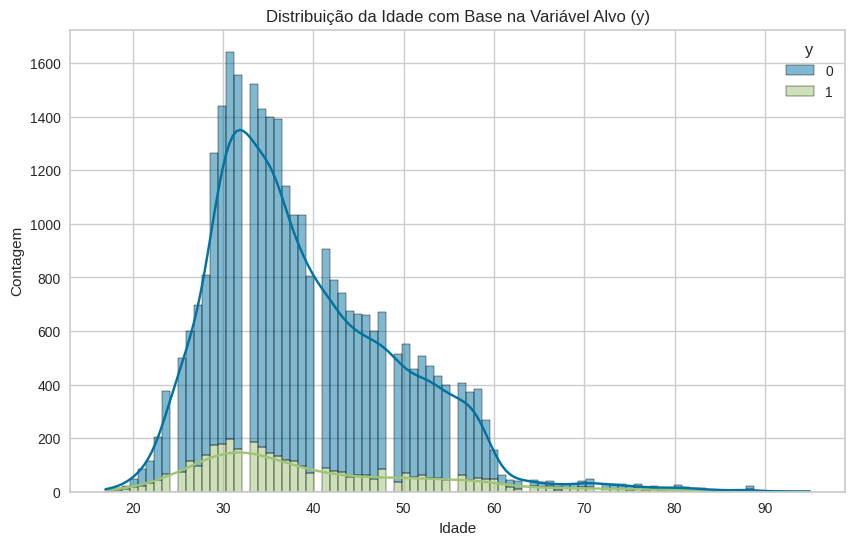

In [391]:
# Configurar o tamanho da figura
plt.figure(figsize=(10,6))

# Gerar o histograma com KDE, usando a variável 'y' como hue
sns.histplot(data=data_PreProcess, x='age', kde=True, hue='y', multiple='stack')

# Configurar título e rótulos dos eixos
plt.title('Distribuição da Idade com Base na Variável Alvo (y)')
plt.xlabel('Idade')
plt.ylabel('Contagem')

# Exibir o gráfico
plt.show()

Podemos observar se há uma faixa etária predominante, aproximadamente entre 28 e 35 anos, que subscreveu um depósito (y='yes').

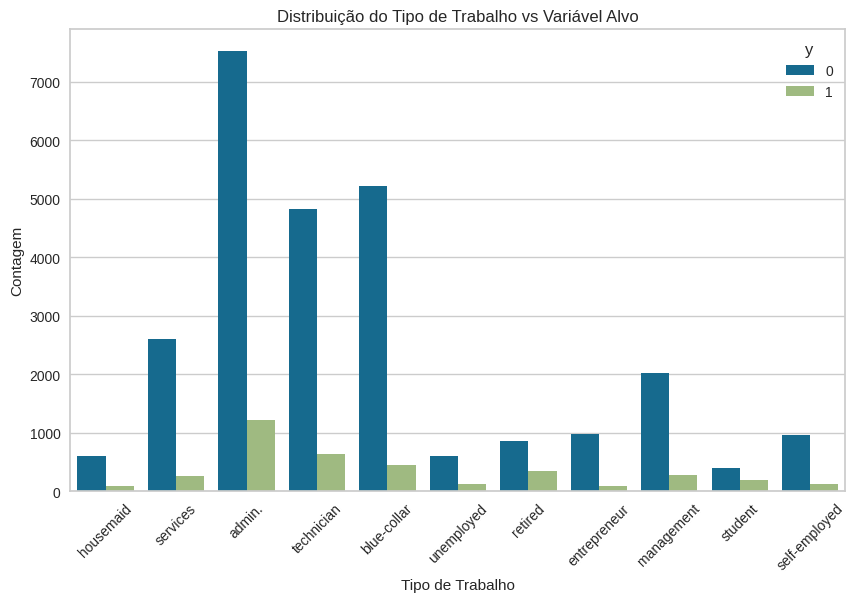

In [392]:
# Configurar o tamanho da figura
plt.figure(figsize=(10,6))

# Gerar o gráfico de contagem com base na variável 'job' e diferenciando pela variável alvo 'y'
sns.countplot(data=data_PreProcess, x='job', hue='y')

# Configurar título e rótulos dos eixos
plt.title('Distribuição do Tipo de Trabalho vs Variável Alvo')
plt.xlabel('Tipo de Trabalho')
plt.ylabel('Contagem')

# Rotacionar os rótulos do eixo X para melhor legibilidade
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

Podemos observar que estudantes (student) possuem a maior relação proporcional entre os que estão dispostos a subscrever um depósito a prazo bancário.

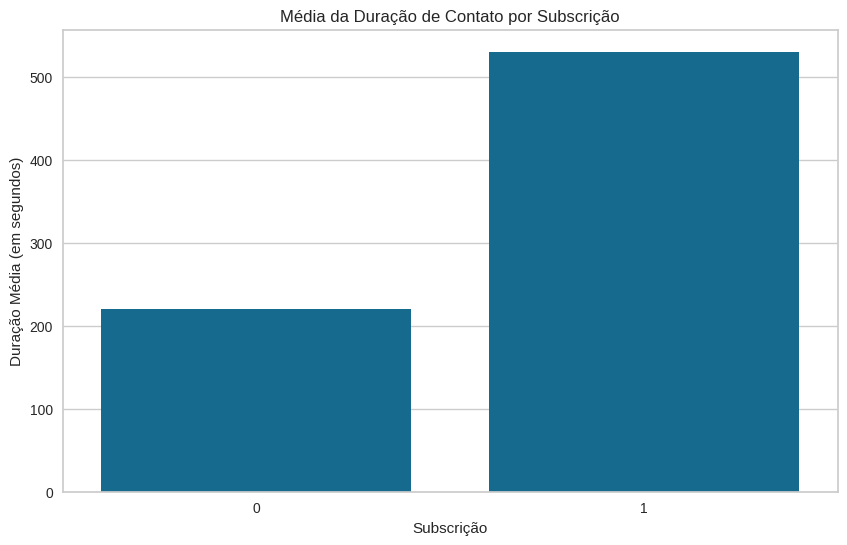

In [393]:
# Calcular a média da duração por subscrição
mean_duration = data_PreProcess.groupby('y')['duration'].mean().reset_index()

# Configurar o tamanho da figura
plt.figure(figsize=(10,6))

# Gerar o gráfico de barras
sns.barplot(data=mean_duration, x='y', y='duration')

# Configurar título e rótulos dos eixos
plt.title('Média da Duração de Contato por Subscrição')
plt.xlabel('Subscrição')
plt.ylabel('Duração Média (em segundos)')

# Exibir o gráfico
plt.show()

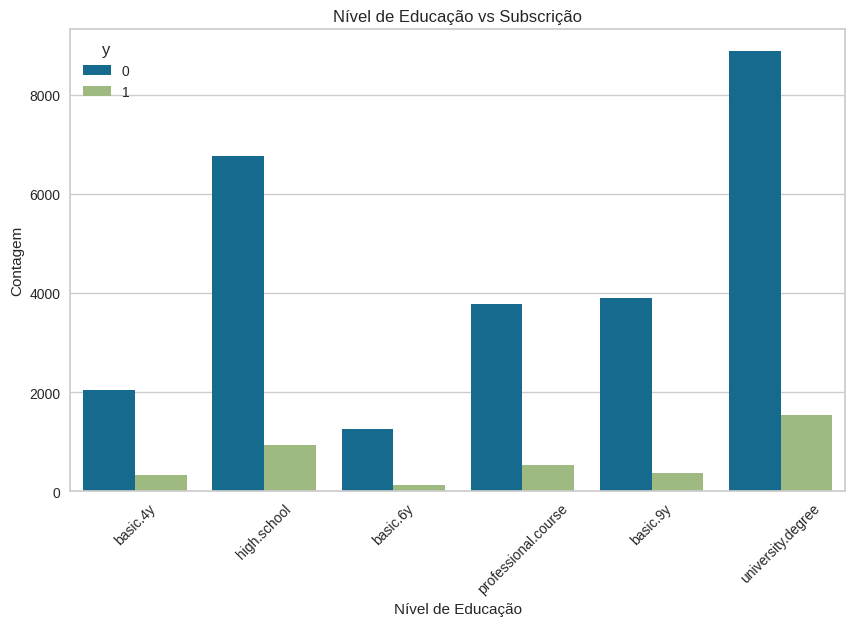

In [394]:
# Configurar o tamanho da figura
plt.figure(figsize=(10,6))

# Gerar o gráfico de contagem (countplot) com base na variável 'education' e diferenciando pela variável 'y'
sns.countplot(data=data_PreProcess, x='education', hue='y')

# Configurar título e rótulos dos eixos
plt.title('Nível de Educação vs Subscrição')
plt.xlabel('Nível de Educação')
plt.ylabel('Contagem')

# Rotacionar os rótulos do eixo X para melhor legibilidade
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

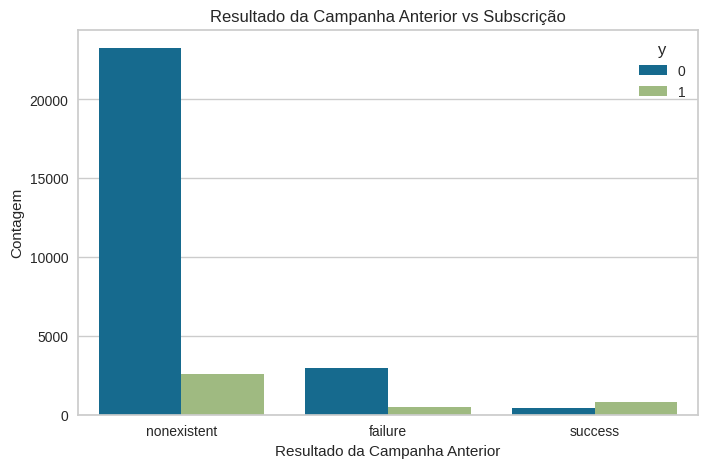

In [395]:
# Configurar o tamanho da figura
plt.figure(figsize=(8,5))

# Gerar o gráfico de contagem (countplot) com base na variável 'poutcome' e diferenciando pela variável alvo 'y'
sns.countplot(data=data_PreProcess, x='poutcome', hue='y')

# Configurar título e rótulos dos eixos
plt.title('Resultado da Campanha Anterior vs Subscrição')
plt.xlabel('Resultado da Campanha Anterior')
plt.ylabel('Contagem')

# Exibir o gráfico
plt.show()

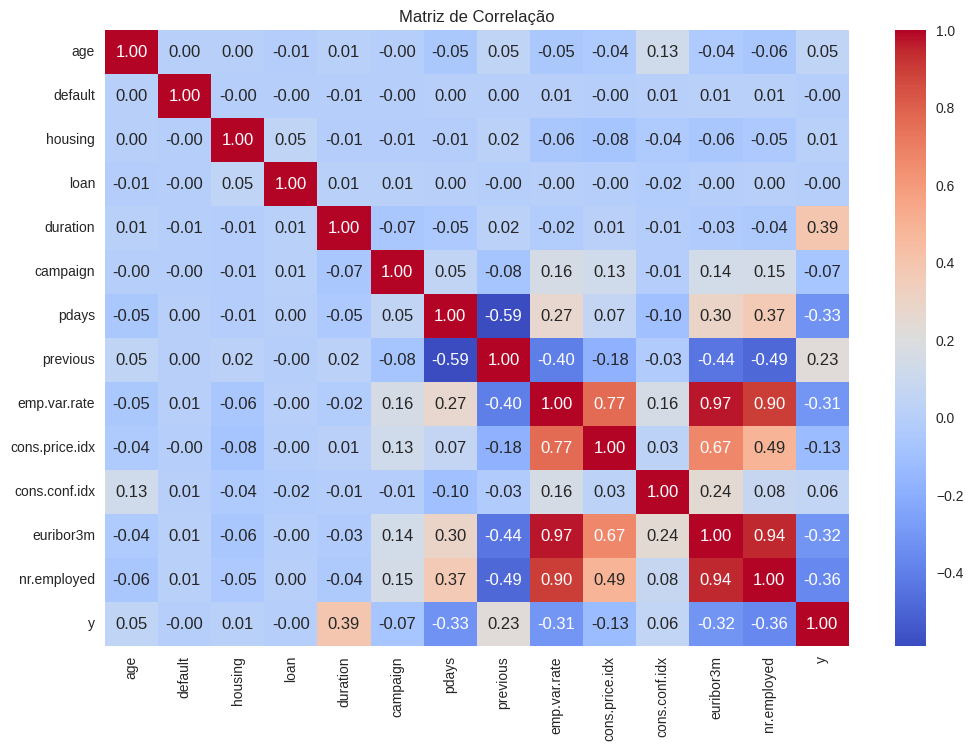

In [397]:
# A matrix só pode ser gerada com variáveis numéricas, portanto é necessário ignorar as colunas categórias

# Filtrando apenas colunas numéricas
numerical_columns = data_PreProcess.select_dtypes(include=[float, int])

# Matriz de correlação entre variáveis numéricas
correlation_matrix = numerical_columns.corr()

# Gerando o heatmap da matriz de correlação
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()


## Relação entre Variáveis Numéricas e a Variável Alvo (y)

* Duração do Contato (**duration**) tem a maior correlação positiva com a variável alvo (**y**), com um coeficiente de 0.39. Isso significa que quanto maior a duração da chamada, maior a chance de que o cliente tenha subscrito um depósito a prazo. ***obs: Essa variável não deve ser usada diretamente para modelos preditivos, pois será conhecida apenas após a interação.***

* **Pdays** tem uma correlação negativa moderada com a variável alvo, com um coeficiente de -0.33. Isso sugere que quanto mais dias se passaram desde que o cliente foi contatado pela última vez, menor a probabilidade de ele subscrever um depósito.

* **Previous** tem uma correlação positiva com a variável alvo de 0.23. Isso indica que clientes que foram contatados anteriormente em campanhas têm uma probabilidade um pouco maior de subscrever o depósito.

## Correlação entre Variáveis Econômicas

* Taxa de Variação de Emprego (**emp.var.rate**) e taxa Euribor de 3 meses (**euribor3m**) possuem uma correlação muito forte (0.97), indicando que essas variáveis estão fortemente relacionadas. Além disso, ambas as variáveis estão correlacionadas negativamente com a variável alvo (**y**), indicando que uma piora nas condições econômicas pode reduzir a chance de subscrição.

* Número de Empregados (**nr.employed**) também está fortemente correlacionado com **euribor3m** (0.94) e **emp.var.rate** (0.90), o que é esperado, dado que essas variáveis refletem condições macroeconômicas semelhantes.

## Correlação entre Variáveis da Campanha

* O número de contatos realizados durante esta campanha (**Campaign**) tem uma correlação ligeiramente positiva com y (0.06), sugerindo que um maior número de tentativas de contato tem uma leve influência positiva, embora essa relação seja muito fraca.

* O número de contatos anteriores (**Previous**) tem uma correlação negativa com **pdays** (-0.59) e uma correlação positiva com a variável alvo **y** (0.23). Isso mostra que clientes que foram contatados antes têm maior chance de subscrever, enquanto um maior intervalo de tempo desde o último contato (medido por pdays) diminui a probabilidade de sucesso.


# Conclusões

* Duração da Chamada é o fator mais influente.

* Variáveis de Campanha, como pdays, previous, e campaign, têm relações interessantes com o alvo, sugerindo que clientes que foram contatados anteriormente e mais recentemente têm maior probabilidade de subscrever.

* Variáveis Econômicas como a taxa de emprego e a taxa Euribor têm impacto negativo na subscrição, indicando que condições econômicas desfavoráveis podem reduzir o interesse dos clientes em subscrever depósitos.

## 3 - Modelagem
* Em seus grupos, os alunos aplicarão modelos de aprendizado de máquina (Regressão Logística, KNN, SVM, Árvores de Decisão, Floresta Aleatória, Naive Bayes) para prever se um cliente irá assinar um depósito a prazo.

* Cada grupo documentará suas escolhas de modelo e configurações de
parâmetros.


In [398]:
# Antes de realizar qualquer tipo de treinamento, é necessário remover a coluna Duration.
# Como visto na análise exploratória, ela é importante para compreender os dados, porém não deve ser utilizada no treinamento de um modelo preditivo, uma vez que os valores só são conhecidos após a interação com o possível cliente.

# Criar o novo DataFrame removendo a coluna 'duration'
data_training = data_PreProcess.drop(columns=['duration'])

# Exibir as primeiras linhas do novo DataFrame para verificar a remoção
data_training.head()


,age,job,marital,education,default,housing,loan,campaign,pdays,previous,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,housemaid,married,basic.4y,0,0,0,0.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
2,37,services,married,high.school,0,1,0,0.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
3,40,admin.,married,basic.6y,0,0,0,0.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
4,56,services,married,high.school,0,0,1,0.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False
6,59,admin.,married,professional.course,0,0,0,0.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,False


In [399]:
# Separação dos dados em teste e treino

# Utiliza 20% para teste
test = data_training.sample(frac=0.2, random_state=42)

# Remove do dataset de treino os 20% de teste
train = data_training.drop(test.index)

In [400]:
# Reorganiza os index
test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

In [403]:
# Criando o pipeline
clf = setup(
    data = train,
    target = 'y',
    normalize = True,
    transformation = True,
    experiment_name = 'teste'
)

,Description,Value
0,Session id,3134
1,Target,y
2,Target type,Binary
3,Original data shape,"(24382, 34)"
4,Transformed data shape,"(24382, 53)"
5,Transformed train set shape,"(17067, 53)"
6,Transformed test set shape,"(7315, 53)"
7,Numeric features,12
8,Categorical features,4
9,Preprocess,True


In [404]:
# Comparação dos modelos
best = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8900,0.8043,0.2496,0.6611,0.3620,0.3150,0.3604,3.8550
ridge,Ridge Classifier,0.8899,0.7938,0.2239,0.6829,0.3367,0.2932,0.3484,1.3540
lr,Logistic Regression,0.8896,0.7957,0.2351,0.6679,0.3473,0.3019,0.3518,1.9240
ada,Ada Boost Classifier,0.8888,0.7984,0.2295,0.6599,0.3400,0.2946,0.3444,2.0810
lightgbm,Light Gradient Boosting Machine,0.8866,0.7975,0.2689,0.6055,0.3720,0.3197,0.3519,2.7290
svm,SVM - Linear Kernel,0.8839,0.7052,0.2186,0.6184,0.3116,0.2653,0.3111,1.5910
xgboost,Extreme Gradient Boosting,0.8818,0.7753,0.2942,0.5526,0.3838,0.3251,0.3450,1.5890
lda,Linear Discriminant Analysis,0.8814,0.7938,0.3494,0.5413,0.4240,0.3614,0.3725,1.2090
rf,Random Forest Classifier,0.8807,0.7769,0.2960,0.5420,0.3827,0.3230,0.3412,3.4470
knn,K Neighbors Classifier,0.8781,0.7183,0.2777,0.5253,0.3628,0.3025,0.3216,1.8410


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [405]:
# Melhor modelo
best

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=3134, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [406]:
# Tuning de parâmetros
tuned_model = tune_model(best, optimize='Accuracy')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8846,0.7802,0.1729,0.6491,0.2731,0.2326,0.2940
1,0.8951,0.7886,0.2477,0.7465,0.3719,0.3301,0.3908
2,0.8858,0.7862,0.2009,0.6418,0.3060,0.2619,0.3152
3,0.8916,0.8089,0.2150,0.7302,0.3321,0.2917,0.3575
4,0.8869,0.7803,0.2150,0.6479,0.3228,0.2777,0.3287
5,0.8899,0.8032,0.2254,0.6761,0.3380,0.2940,0.3475
6,0.8934,0.7957,0.2441,0.7123,0.3636,0.3203,0.3758
7,0.8816,0.8033,0.1502,0.6038,0.2406,0.2008,0.2594
8,0.8880,0.7749,0.1784,0.7037,0.2846,0.2466,0.3166


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## 4 - Avaliação do Modelo

* Avaliar o desempenho do modelo usando métricas como acurácia, precisão, recall, F1 score e ROC-AUC.

* Discutir a importância dessas métricas em um contexto bancário, especialmente em relação à avaliação de risco.


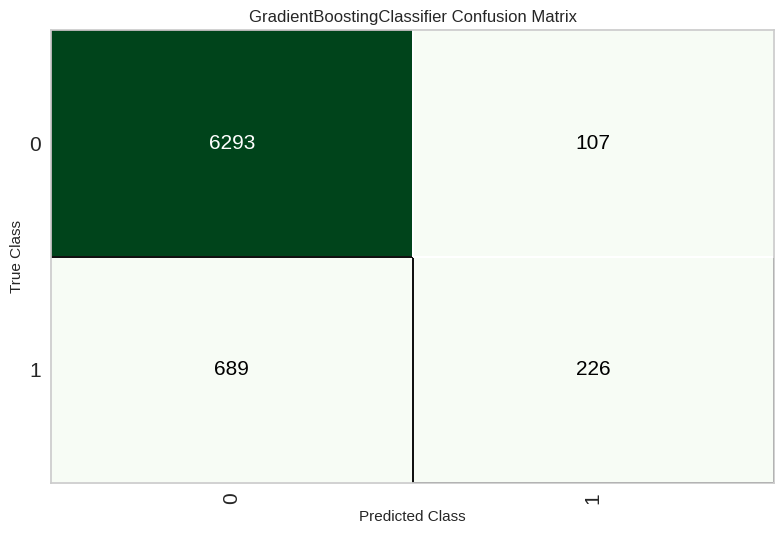

In [407]:
# Plotar a Matriz de Confusão

# Utilizando o modelo sem tuning, uma vez que não ouve melhora
plot_model(best, plot='confusion_matrix')

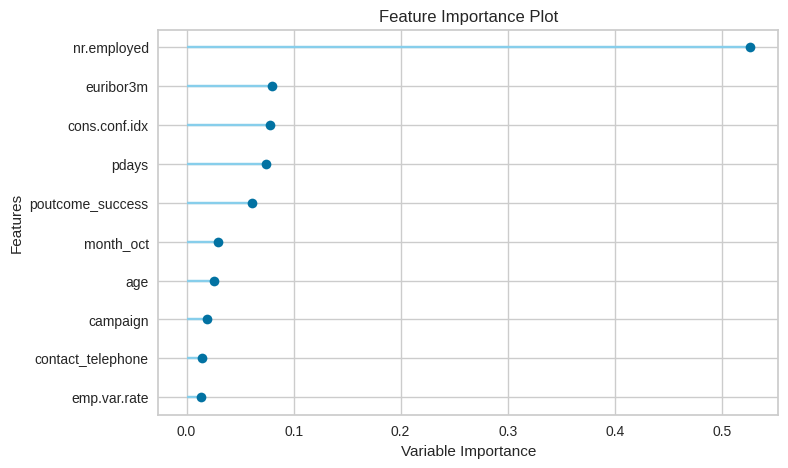

In [408]:
# Importância das variáveis
plot_model(best, plot='feature')

In [409]:
# Avaliação do modelo
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [410]:
# Finaliza o modelo
best_final = finalize_model(best)

In [411]:
best_final

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'default', 'housing',
                                             'loan', 'campaign', 'pdays',
                                             'previous', 'emp.var.rate',
                                             'cons.price.idx', 'cons.conf.idx',
                                             'euribor3m', 'nr.employed'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing...
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='log_loss',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            random_state=3134, subsample=1.0,
                                            tol=0.0001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
         verbose=False)

## Importância das Métricas no Contexto Bancário



*   **Acurácia**: A acurácia por si só pode não ser a melhor métrica para avaliar modelos de risco financeiro, uma vez que existe um desequilibro de respostas "sim" e "não", o que pode levar a um desequilíbrio de classe. No contexto bancário, pode haver muitos clientes que não subscrevem o depósito, o que inflaria a acurácia sem refletir verdadeiramente a performance do modelo em prever os clientes que realmente subscrevem o depósito.

*   **Precisão**: Alta precisão é importante para minimizar falsos positivos, o que é crucial em um negócio a fim de evitar alocar recursos excessivos de marketing para clientes que não irão subscrever o depósito.

*   **Recall**: Reflete a capacidade do modelo de identificar corretamente todos os clientes que de fato subscreveriam um depósito, isso pode ajudar a garantir que poucos clientes potenciais sejam ignorados em campanhas de marketing.

*   **F1 Score**: É a média harmônica entre precisão e recall. Se o banco quiser um equilíbrio entre não perder clientes potenciais e evitar muitos falsos positivos, o F1-Score permitirá encontrar um ponto de equilíbrio entre capturar clientes potenciais (recall) e minimizar o desperdício de recursos (precisão).

*   **ROC-AUC**: É uma métrica que avalia a capacidade do modelo em separar as classes positivas e negativas em diferentes limiares de decisão. Um valor de ROC-AUC perto de 1 indica que o modelo é bom em classificar corretamente as duas classes (clientes que subscrevem e não subscrevem). No setor bancário, onde a avaliação de risco é fundamental, o ROC-AUC é uma métrica crucial, pois permite medir a capacidade do modelo em distinguir entre clientes de alto e baixo risco de não subscrição. Também é útil em problemas de classes desequilibradas, como este, para avaliar o desempenho geral do modelo.



In [421]:
# Salvar o modelo
joblib.dump(best_final, '/content/drive/MyDrive/Pessoal/Educação/Católica de Santa Catarina - Pós-Graduação/09 - Avaliação de Resultados e Análise de Dados com IA/Trabalho Final/CatolicaSC_AvaliacaoAnaliseResultados_Entrega01/modelo_final.pkl')

['/content/drive/MyDrive/Pessoal/Educação/Católica de Santa Catarina - Pós-Graduação/09 - Avaliação de Resultados e Análise de Dados com IA/Trabalho Final/CatolicaSC_AvaliacaoAnaliseResultados_Entrega01/modelo_final.pkl']

In [435]:
# Carregar o modelo salvo
FinalModel = joblib.load('/content/drive/MyDrive/Pessoal/Educação/Católica de Santa Catarina - Pós-Graduação/09 - Avaliação de Resultados e Análise de Dados com IA/Trabalho Final/CatolicaSC_AvaliacaoAnaliseResultados_Entrega01/modelo_final.pkl')

## 5 - Técnicas de Explicabilidade

* Usar SHAP ou LIME para explicar previsões individuais.

* Analisar a importância das características para entender quais atributos
mais influenciam os resultados do modelo.

* Discutir como apresentar essas descobertas a partes interessadas não
técnicas.


In [436]:
print(train.columns)
print(test.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed'],
      dtype='object')
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'da

In [437]:
# Criar o explicador LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train.values,
    feature_names=train.columns.tolist(),
    class_names=['no', 'yes'],  # classes para a variável alvo 'y'
    mode='classification'
)

# Explicar a primeira instância do conjunto de teste
i = 0  # índice da instância
instance = test.iloc[i].values.reshape(1, -1)

# Gerar a explicação para a instância
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=FinalModel.predict_proba
)

# Mostrar a explicação
explanation.show_in_notebook(show_table=True)


TypeError: unsupported operand type(s) for -: 'str' and 'str'